In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Paths to the dataset directories
train_dir = "C:\\Users\\K.DEVI PRASAD\\Downloads\\vit\\fer2013plus\\fer2013\\train"
test_dir = "C:\\Users\\K.DEVI PRASAD\\Downloads\\vit\\fer2013plus\\fer2013\\test"

# Define image size and batch size
img_size = 224
batch_size = 32

# Define ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Get the class labels
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)


C:\Users\K.DEVI PRASAD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Class labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [7]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = layers.Conv2D(filters=256, kernel_size=(16, 16), strides=(16, 16), padding="valid")(inputs)
    patches = layers.Reshape((-1, patches.shape[-1]))(patches)
    encoded_patches = layers.Dense(units=128, activation="relu")(patches)
    for _ in range(4):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=128, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=128, activation="relu")(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    logits = layers.Dense(num_classes)(representation)
    model = models.Model(inputs=inputs, outputs=logits)
    return model

model_save_path = "C:\\Users\\K.DEVI PRASAD\\Downloads\\vit\\fer2013plus\\fer2013\\vit_model.h5"

# Check if a saved model exists
if os.path.exists(model_save_path):
    vit_model = tf.keras.models.load_model(model_save_path)
    print("Loaded saved model.")
else:
    vit_model = create_vit_model((img_size, img_size, 3), len(class_labels))
    vit_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    vit_model.summary()

    history = vit_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=20,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    # Save the trained model
    vit_model.save(model_save_path)
    print(f"Model saved at {model_save_path}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │    196,864 │ input_layer_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 196, 256)  │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 196, 128)  │     32,896 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ dense_12[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 196, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 196, 128)  │          0 │ dense_13[0][0],   │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 196, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 196, 128)  │          0 │ dense_14[0][0],   │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 1,554,056 (5.93 MB)

 Trainable params: 1,554,056 (5.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.2946 - loss: 2.2453

C:\Users\K.DEVI PRASAD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


888/888 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - accuracy: 0.2947 - loss: 2.2451 - val_accuracy: 0.4267 - val_loss: 1.5265
Epoch 2/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 858s 966ms/step - accuracy: 0.4176 - loss: 1.5684 - val_accuracy: 0.4674 - val_loss: 1.4392
Epoch 3/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 841s 947ms/step - accuracy: 0.4707 - loss: 1.4392 - val_accuracy: 0.5067 - val_loss: 1.3917
Epoch 4/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 839s 944ms/step - accuracy: 0.4878 - loss: 1.4018 - val_accuracy: 0.5247 - val_loss: 1.3532
Epoch 5/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 839s 944ms/step - accuracy: 0.5071 - loss: 1.3481 - val_accuracy: 0.5182 - val_loss: 1.3450
Epoch 6/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 830s 934ms/step - accuracy: 0.5276 - loss: 1.2968 - val_accuracy: 0.5470 - val_loss: 1.2722
Epoch 7/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 832s 937ms/step - accuracy: 0.5537 - loss: 1.2305 - val_accuracy: 0.5567 - val_loss: 1.2393
Epoch 8/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 836s 941ms/step - accuracy: 0.5719 - loss: 1.1707 

Model saved at C:\Users\K.DEVI PRASAD\Downloads\vit\fer2013plus\fer2013\vit_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 309ms/step


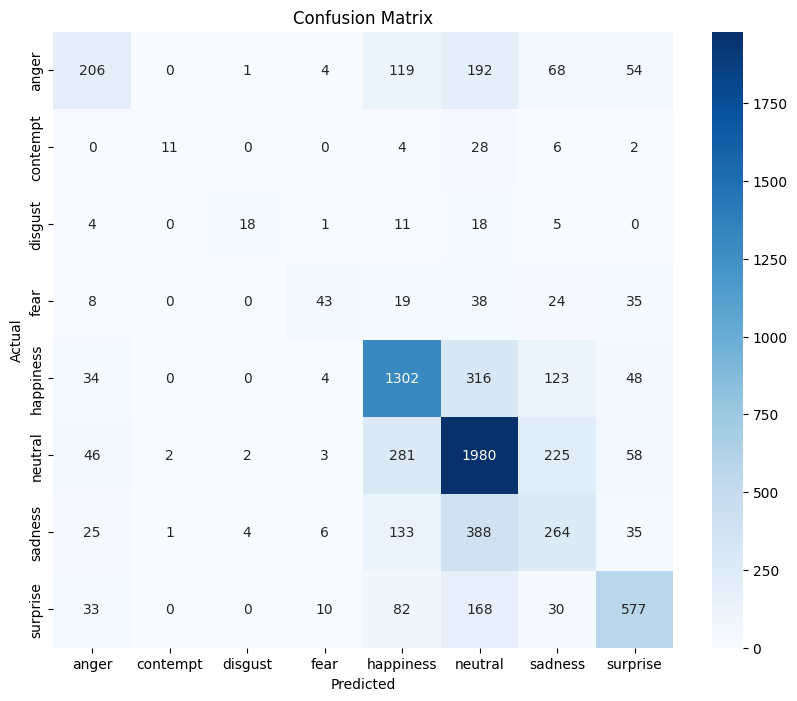

In [10]:
# Evaluate the model
y_true = test_generator.classes
y_pred = vit_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
# Evaluate the model
y_true = test_generator.classes
y_pred = vit_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
plt.show()

222/222 ━━━━━━━━━━━━━━━━━━━━ 68s 304ms/step
Accuracy: 61.99%

Classification Report:
               precision    recall  f1-score   support

    surprise       0.58      0.32      0.41       644
     sadness       0.79      0.22      0.34        51
     neutral       0.72      0.32      0.44        57
   Happiness       0.61      0.26      0.36       167
        fear       0.67      0.71      0.69      1827
     disgust       0.63      0.76      0.69      2597
    contempt       0.35      0.31      0.33       856
       anger       0.71      0.64      0.68       900

    accuracy                           0.62      7099
   macro avg       0.63      0.44      0.49      7099
weighted avg       0.61      0.62      0.61      7099



C:\Users\K.DEVI PRASAD\AppData\Local\Temp\ipykernel_13272\1309020854.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [43]:
import tensorflow as tf
import numpy as np
import cv2
import os
import time
from PIL import Image, ImageDraw, ImageFont

# Define image size
img_size = 224

print("Loading model...")
# Load the trained model
vit_model = tf.keras.models.load_model("C:\\Users\\K.DEVI PRASAD\\Downloads\\vit\\fer2013plus\\fer2013\\vit_model.h5")
print("Model loaded successfully.")

# Get the class labels (adjust according to your dataset)
class_labels = ['surprise', 'sadness', 'neutral', 'Happiness', 'fear', 'disgust', 'contempt', 'anger']

# Function to preprocess a single frame
def preprocess_frame(frame):
    resized_frame = cv2.resize(frame, (img_size, img_size))
    normalized_frame = resized_frame / 255.0
    return np.expand_dims(normalized_frame, axis=0)

print("Opening camera...")
# Real-time emotion recognition
cap = cv2.VideoCapture(0)  # Use your webcam
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()
print("Camera opened successfully.")

# Create a temporary directory to store frames
temp_dir = "temp_frames"
os.makedirs(temp_dir, exist_ok=True)

# Try to load a default font
try:
    font = ImageFont.truetype("arial.ttf", 30)
except:
    font = ImageFont.load_default()

print("Starting real-time emotion recognition. Press Ctrl+C to stop.")
frame_count = 0
try:
    while True:
        print("Reading frame...")
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        print("Preprocessing frame...")
        preprocessed_frame = preprocess_frame(frame)
      
        print("Predicting emotion...")
        prediction = vit_model.predict(preprocessed_frame)
        emotion = class_labels[np.argmax(prediction)]
        print(f"Predicted emotion: {emotion}")

        # Use PIL to add text to the frame
        pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_frame)
        draw.text((10, 30), emotion, font=font, fill=(255, 255, 255))
        frame = cv2.cvtColor(np.array(pil_frame), cv2.COLOR_RGB2BGR)
        
        # Save the frame as an image
        frame_path = os.path.join(temp_dir, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_path, frame)
        
        # Open the image with the default viewer (this will overwrite the previous frame)
        os.startfile(frame_path)
        
        frame_count += 1
        
        # Short sleep to control the frame rate and CPU usage
        time.sleep(0.1)  # Adjust as needed

except KeyboardInterrupt:
    print("\nEmotion recognition stopped by user.")

finally:
    cap.release()
    print("Cleaning up...")
    # Clean up temporary files
    for file in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, file))
    os.rmdir(temp_dir)
    print("Done.")

Loading model...


Model loaded successfully.
Opening camera...
Camera opened successfully.
Starting real-time emotion recognition. Press Ctrl+C to stop.
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted emotion: fear
Reading frame...
Preprocessing frame...
Predicting emotion...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted emotion: f